# Counting grains and bubbles

This notebook was originally created by Stefan van der Walt and was presented at the 2012 PyData conference in New York City. The original notebook can be found on Github [here](https://github.com/stefanv/teaching/blob/master/2012_pydata_nyc_skimage/sand_grain_problem.ipynb).

This Scanning Element Microscopy image shows a glass sample (light gray matrix) with some bubbles (black) and unmolten
sand grains (dark gray). We wish to determine the fraction of the sample covered by these three phases, and to estimate the number of sand grains and bubbles, their average sizes, etc.

This notebook has been edited by J. R. Minter to make it compatible with Python 3.5.1 in Anaconda 2.4.1. I also want to store this in a GitHub repository where I can use relative paths to compile it from multiple computers running different operating systems, so I will use environment variables.

## First, import the packages we need

I like to put this all up front and include any notebook magic that is helpful.

In [1]:
%matplotlib inline
import os, math
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import warnings
# plt.rcParams['figure.figsize'] = 8,5

warnings.filterwarnings('ignore')

# Loading the data

Let's input some calibration data we need, set the path variables, and load the image.

In [2]:
sizeFont=12
umPerPx = 314./1000.

gitDir = os.environ['GIT_HOME']
semImgPth = gitDir + os.sep + 'OSImageAnalysis' + os.sep 
semImgPth +=  'images' + os.sep + 'scipy_ex_MV_HFV_012.jpg'
semImgPth

'/Users/jrminter/git/OSImageAnalysis/images/scipy_ex_MV_HFV_012.jpg'

In [3]:
dat = plt.imread(semImgPth)
print(dat.shape)

(943, 1024)


We will want to repeatedly plot an image with a label. We will use the **DRY** principle (do not repeat yourself and write a function. We want this to return a unique ID for a matplotlib plot that we can display. We also want a function to plot three images side by side. 

In [4]:
def jmPlotOneImage(data, lab="Title", fontSize=12, size=(10,10)):
    """jmPlotOneImage(data, lab="Title", size=(10,10))
    Plot an image with a title in a clean layout.
    Input:
    data - a numpy array
    lab  - s string label (default = 'Title')
    fontSize - an integer font size, default = 12
    size - a tuple (default = (10,10))
    Returns:
    a pyplot fig"""
    theFig, axes = plt.subplots(ncols=1, nrows=1, figsize=size)
    ax0 = axes 
    ax0.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
    ax0.set_title(lab, fontsize=sizeFont)
    ax0.axis('off')
    theFig.tight_layout()
    theFig.show()
    return (theFig)

def jmPlotThreeImages(lData, lLabs=["0","1","2"], fontSize=12, size=(10,10)):
    """jmPlotThreeImages([data0, data1, data2], lLabs=["0","1","2"], 
                         fontSize=12, size=(10,10))
    Plot three images side-by-side, each with a title in a clean layout.
    Input:
    lData - a list with three numpy arrays
    lLabs - a list of three string label (default = ["0","1","2"])
    fontSize - an integer font size, default = 12
    size - a tuple (default = (10,10))
    Returns:
    a pyplot fig"""
    theFig, axes = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
    ax0, ax1, ax2 = axes.flat 
    ax0.imshow(lData[0], cmap=plt.cm.gray)
    ax0.set_title(lLabs[0], fontsize=fontSize)
    ax0.axis('off')
    ax1.imshow(lData[1], cmap=plt.cm.gray)
    ax1.set_title(lLabs[1], fontsize=fontSize)
    ax1.axis('off')
    ax2.imshow(lData[2], cmap=plt.cm.gray)
    ax2.set_title(lLabs[2], fontsize=fontSize)
    ax2.axis('off')
    theFig.tight_layout()
    theFig.show()
    return(theFig)

Now let's display the original image

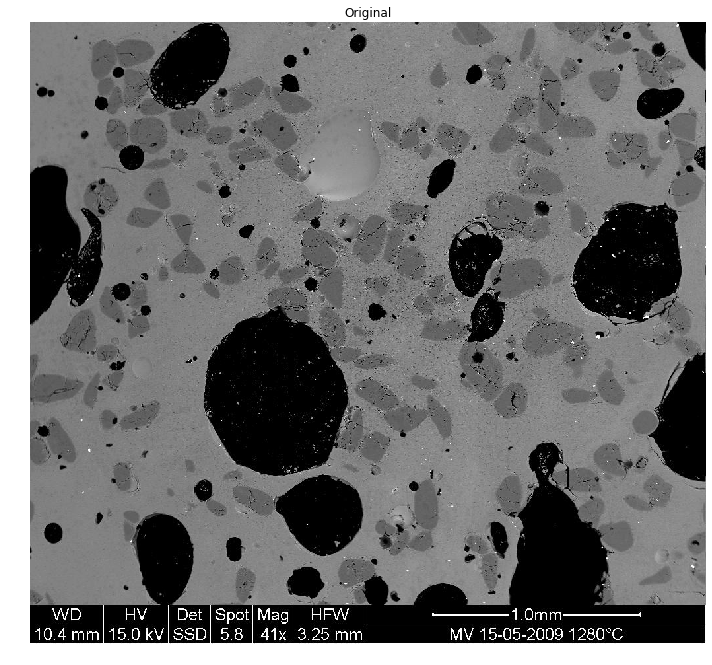

In [5]:
oriFig = jmPlotOneImage(dat, lab="Original", fontSize=sizeFont)
oriFig.show()

## Remove banner

The banner at the bottom interferes with the image processing. We remove it. I calibrated the image using ImageJ to get the value of `umPerPx` shown at the top. This is the perfect time to reuse our `jmPlotOneImage()` function. 

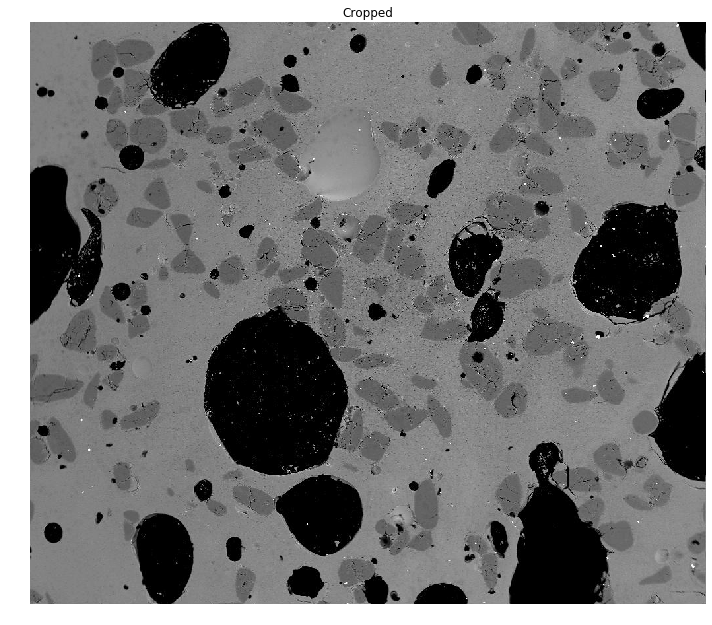

In [6]:
cr = dat[:-60]
crFig = jmPlotOneImage(cr, lab="Cropped", fontSize=sizeFont)
crFig.show()

## Filter to get rid of speckles

The white noise speckles remaining in the image interfere with the image processing. We need to remove them. We will use a 7x7 median filter. This filter removes noise without moving edge boundaries.

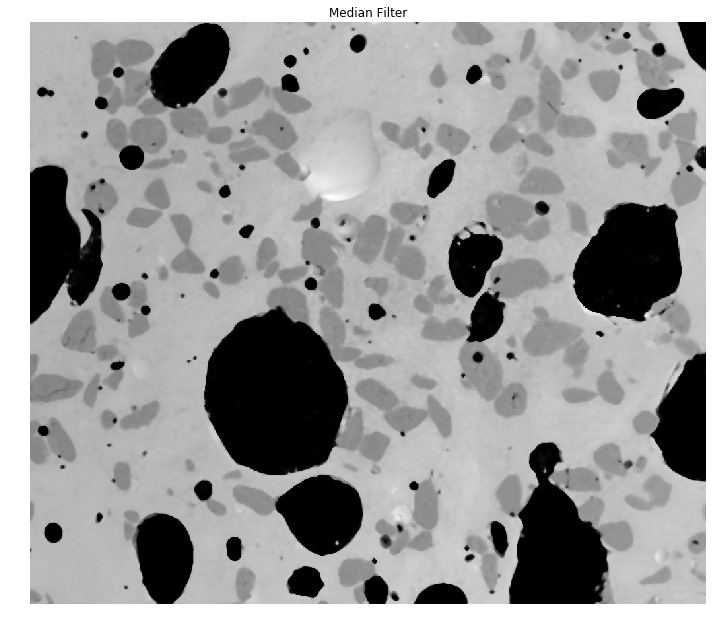

In [7]:
filtdat = ndimage.median_filter(cr, size=(7,7))
mfFig = jmPlotOneImage(filtdat, lab="Median Filter", fontSize=sizeFont)
mfFig.show()

## Find threshold values

We need to find the threshold values. The best way is to look at the gray level histogram of our cropped and median filtered images. This will guide in selecting gray level thresholds for each of the phases. 

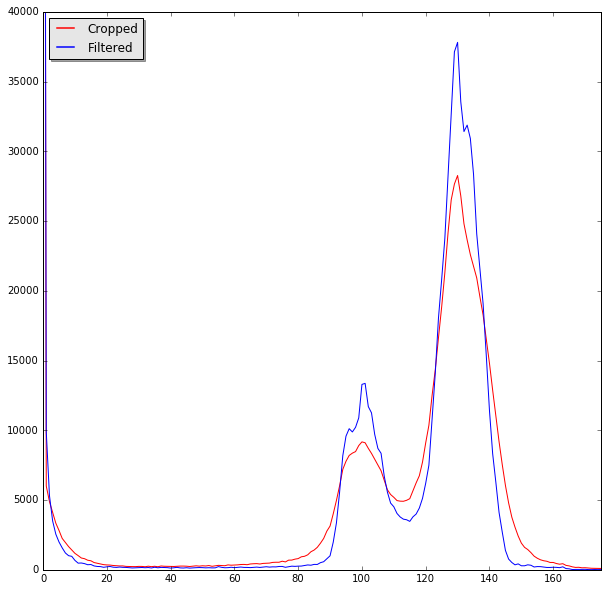

In [8]:
hi_dat, bin_edges = np.histogram(cr, bins=np.arange(256))
hi_filtdat, bin_edges = np.histogram(filtdat, bins=np.arange(256))

hFig, ax = plt.subplots(figsize=(10,10))
ax.plot(bin_edges[:-1], hi_dat, linewidth=1.0, color='r', label='Cropped')
ax.plot(bin_edges[:-1], hi_filtdat, linewidth=1.0, color='b', label='Filtered')

legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
hFig.show()
ax.set_xlim([0,175])
ax.set_ylim([0,40000])
hFig.show()

## Separate layers by thresholding

Note that we can see how the median filter sharpened the maxima in the gray level histogram. We see that we can set any pixel below 50 to be a "bubble", any pixel between 50 and 114 to be "sand" and any pixel between 114 and 255 to be "glass". Let's see how these look as gray scale images.

In [9]:
void = filtdat <= 50
sand = np.logical_and(filtdat > 50, filtdat <= 114)
glass = filtdat > 114

Let's take a look at the images...

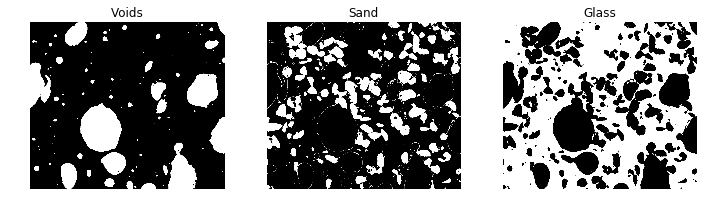

In [10]:
pFig = jmPlotThreeImages([void,sand,glass], lLabs=["Voids","Sand","Glass"],
                         fontSize=12, size=(10,10))
pFig.show()

## Show phases

Display an image in which the three phases are colored with three different colors. note that I changed the order between sand and glass to make it match intensity I like this display **much** better than original. I also like the `viridis` map too. We need a good 3 color map for this and want to avoid R/G/B maps because of R/G color blindness issues...

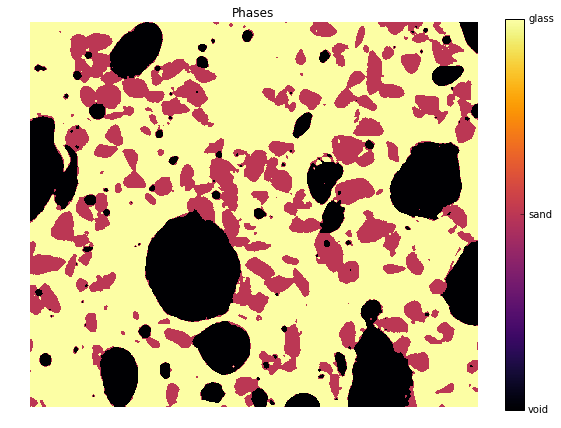

In [11]:
phases = void.astype(np.int)+ 2*sand.astype(np.int) + 3*glass.astype(np.int)
# now the plot..
phFig, pAx = plt.subplots(ncols=1, nrows=1, figsize=(10,7))
im = pAx.imshow(phases, interpolation='nearest', cmap=plt.cm.inferno) 
pAx.set_title('Phases', fontsize=sizeFont)
cbar = phFig.colorbar(im, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(['void', 'sand', 'glass']) 
pAx.axis('off')
phFig.show()

### Label connected components

Use mathematical morphology to clean the sand image. Attribute labels to all bubbles and sand grains, and remove from the sand mask grains that are smaller than 10 pixels. To do so, use ndimage.sum or np.bincount to compute the grain sizes.

In [12]:
# Convert to int so we can store the labels
sand_op = ndimage.binary_opening(sand, iterations=2)
sand_labels, sand_nb = ndimage.label(sand_op)
sand_areas = np.array(ndimage.sum(sand_op, sand_labels, np.arange(sand_labels.max()+1)))
mask = sand_areas > 100
remove_small_sand = mask[sand_labels.ravel()].reshape(sand_labels.shape)

## Compute the mean area of the bubbles/voids

In [13]:
bubbles_labels, bubbles_nb = ndimage.label(void)
bubbles_areas = np.bincount(bubbles_labels.ravel())[1:]
mean_bubble_size = bubbles_areas.mean()
median_bubble_size = np.median(bubbles_areas)
bubble_count = len(bubbles_areas)
print ((mean_bubble_size, median_bubble_size, bubble_count))

(1699.875, 65.0, 104)


## Compute the diameter 

As a microscopist who has done a lot of particle sizing, most of my clients think in terms of diameter distributions.

In [14]:
bubble_diam_um = 2.0*umPerPx*np.sqrt(bubbles_areas/math.pi)
mu_bubble_diam_um = bubble_diam_um.mean()
sd_bubble_diam_um = bubble_diam_um.std()
median_bubble_diam_um = np.median(bubble_diam_um)
print("bubble diameter microns:")
strLine  = "mean %.3f, "   % mu_bubble_diam_um
strLine += "mean %.3f, "   % sd_bubble_diam_um
strLine += "median %.3f, " % median_bubble_diam_um 
strLine += "count %.3f, "  % bubble_count
print(strLine)

bubble diameter microns:
mean 7.757, mean 12.378, median 2.854, count 104.000, 


This is a really broad distribution. One would need to measure **a lot of fields to get meaningful statistics!!!** So let's plot the distribution

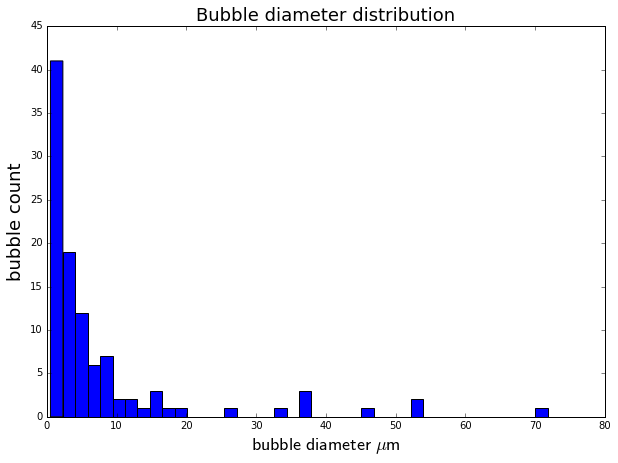

In [15]:
diaHisFig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,7))
plt.hist(bubble_diam_um, bins=40)
diaHistFig = plt.gcf()
ca = diaHistFig.gca()
ca.set_xlabel(r'$\mathsf{bubble\ diameter\ \mu m}$', fontsize=18)
ca.set_ylabel('bubble count', fontsize=18)
ca.set_title('Bubble diameter distribution', fontsize=18)
diaHistFig.show()

Note the **fat tail**!

In [16]:
%reload_ext load_style
%load_style ../themes/tutorial.css